In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot  as plt

from sklearn.preprocessing import OneHotEncoder

sns.set_theme(style = "whitegrid")

In [2]:
INDEX_TO_SEASON = {
    1: 'Primavera',
    2: 'Verão',
    3: 'Outono',
    4: 'Inverno'
}
INDEX_TO_WEATHER = {
    1: "Limpo/Parcialmente Nublado",
    2: "Neblina",
    3: "Neve/Chuvoso",
    4: "Chuva Forte/Neve + Névoa",
}
N_LAGS = 48

In [3]:
bikes = pd.read_csv("data/train.csv")
bikes = bikes.astype({"datetime":"datetime64[ns]"}).set_index("datetime")
bikes = bikes.drop(columns=["casual", "registered"])

bikes["season"] = bikes["season"].apply(lambda x: INDEX_TO_SEASON[x])
bikes["holiday"] = bikes["holiday"].apply(lambda x: "Sim" if x == 1 else "Não")
bikes["workingday"] = bikes["workingday"].apply(lambda x: "Sim" if x == 1 else "Não")
bikes["weather"] = bikes["weather"].apply(lambda x: INDEX_TO_WEATHER[x])

In [4]:
# quebrando por mês para fazer o foward fill, sem isso o asfreq insere muitos NaNs (os últimos dias de cada mês)
bikes_monthly = {(month.year, month.month):group.asfreq("H") for month, group in bikes.groupby(pd.Grouper(freq='1M'))}

groups = []
for month, group in bikes_monthly.items():
    nans = group.isna().any(axis=1).sum()
    if nans > 0:
        print(f"{month}: {nans} NaNs")
    for lag in range(1, N_LAGS + 1):
        group[f"lagged_count_{lag}"] = group["count"].shift(lag)
    groups.append(group.ffill())

bikes = pd.concat(groups)

(2011, 1): 25 NaNs
(2011, 2): 10 NaNs
(2011, 3): 10 NaNs
(2011, 4): 1 NaNs
(2011, 9): 3 NaNs
(2011, 10): 1 NaNs
(2012, 1): 3 NaNs
(2012, 2): 1 NaNs
(2012, 3): 1 NaNs
(2012, 4): 2 NaNs
(2012, 11): 1 NaNs


In [5]:
bikes_monthly

{(2011,
  1):                         season holiday workingday                     weather  \
 datetime                                                                        
 2011-01-01 00:00:00  Primavera     Não        Não  Limpo/Parcialmente Nublado   
 2011-01-01 01:00:00  Primavera     Não        Não  Limpo/Parcialmente Nublado   
 2011-01-01 02:00:00  Primavera     Não        Não  Limpo/Parcialmente Nublado   
 2011-01-01 03:00:00  Primavera     Não        Não  Limpo/Parcialmente Nublado   
 2011-01-01 04:00:00  Primavera     Não        Não  Limpo/Parcialmente Nublado   
 ...                        ...     ...        ...                         ...   
 2011-01-19 19:00:00  Primavera     Não        Sim  Limpo/Parcialmente Nublado   
 2011-01-19 20:00:00  Primavera     Não        Sim  Limpo/Parcialmente Nublado   
 2011-01-19 21:00:00  Primavera     Não        Sim  Limpo/Parcialmente Nublado   
 2011-01-19 22:00:00  Primavera     Não        Sim  Limpo/Parcialmente Nublado   
 20

In [70]:
bikes = bikes.astype({
    "count" : int,
    "humidity" : int,
})

In [71]:
categorical_columns = ["season", "weather", "holiday", "workingday"]

for col in categorical_columns:
    ohe = OneHotEncoder(sparse=False,)
    new_cols = ohe.fit_transform(bikes[[col]])
    ohe.categories_
    bikes[[f"{col}={c}" for c in ohe.categories_[0]]] = new_cols

In [72]:
bikes = bikes.drop(columns = categorical_columns)

In [73]:
bikes

,temp,atemp,humidity,windspeed,count,lagged_count_1,lagged_count_2,lagged_count_3,lagged_count_4,lagged_count_5,...,season=Primavera,season=Verão,weather=Chuva Forte/Neve + Névoa,weather=Limpo/Parcialmente Nublado,weather=Neblina,weather=Neve/Chuvoso,holiday=Não,holiday=Sim,workingday=Não,workingday=Sim
datetime,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,9.84,14.395,81,0.0000,16,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2011-01-01 01:00:00,9.02,13.635,80,0.0000,40,16.0,NaN,NaN,NaN,NaN,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2011-01-01 02:00:00,9.02,13.635,80,0.0000,32,40.0,16.0,NaN,NaN,NaN,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2011-01-01 03:00:00,9.84,14.395,75,0.0000,13,32.0,40.0,16.0,NaN,NaN,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2011-01-01 04:00:00,9.84,14.395,75,0.0000,1,13.0,32.0,40.0,16.0,NaN,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-19 19:00:00,15.58,19.695,50,26.0027,336,569.0,562.0,334.0,237.0,218.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2012-12-19 20:00:00,14.76,17.425,57,15.0013,241,336.0,569.0,562.0,334.0,237.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2012-12-19 21:00:00,13.94,15.910,61,15.0013,168,241.0,336.0,569.0,562.0,334.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [74]:
# Box plot para análise de outliers (em variáveis não categóricas)

non_categorical = ["temp","atemp","humidity","windspeed", *[f"lagged_count_{lag}" for lag in range(1, N_LAGS + 1)]]

# Normalização de valores (min max)
normalized_bikes = (bikes - bikes.min()) / (bikes.max() - bikes.min())

def plot_boxplot(bikes: pd.DataFrame, save=True, plot=False):
    fig, ax = plt.subplots(figsize=(18, 8))
    
    ax.set_title('Boxplot dos dados não categóricos normalizados', weight='bold', fontsize=25)
    data = pd.melt(bikes)
    data.rename(columns={"variable": "atributos", "value": "valores"}, inplace=True)
    sns.boxplot(x="atributos", y="valores",data=data)

    ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)
    ax.xaxis.set_tick_params(labelsize=20)
    ax.yaxis.set_tick_params(labelsize=20)
    
    if save:
        fig.savefig(f"preproc/pre_outlier_boxplot.png")
    
    if not plot:
        plt.close()

    return fig

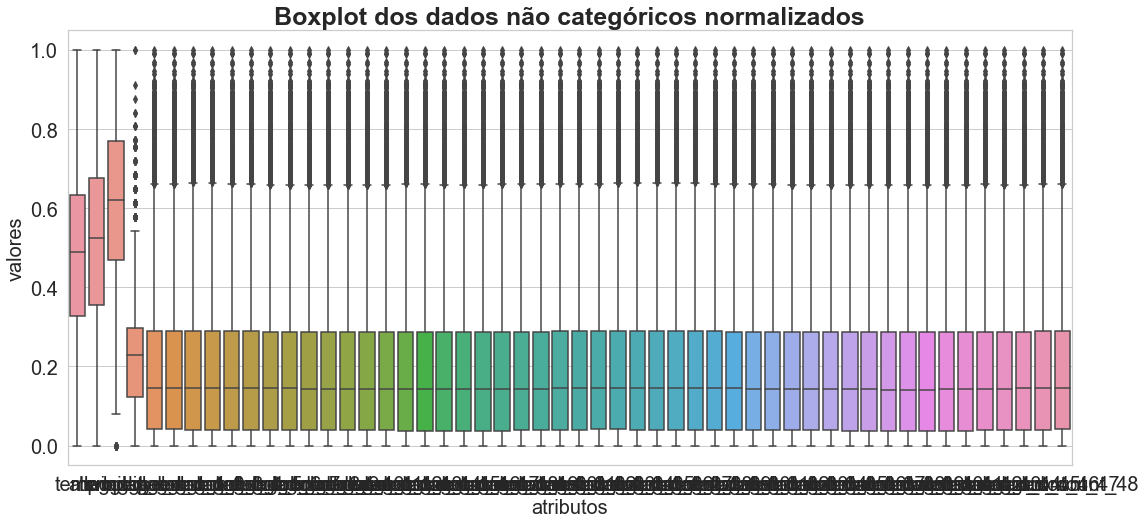

In [75]:
plot_boxplot(normalized_bikes[non_categorical])

In [76]:
categorical_features = [
    "season=Inverno",
    "season=Outono",
    "season=Primavera",
    "season=Verão",
    "weather=Chuva Forte/Neve + Névoa",
    "weather=Limpo/Parcialmente Nublado",
    "weather=Neblina",
    "weather=Neve/Chuvoso",
    "holiday=Não",
    "holiday=Sim",
    "workingday=Não",
    "workingday=Sim",
]

numerical_features = [
    "temp",
    "atemp",
    "humidity",
    "windspeed",
]

features = categorical_features + numerical_features
target = "count"

In [77]:
bikes

,temp,atemp,humidity,windspeed,count,lagged_count_1,lagged_count_2,lagged_count_3,lagged_count_4,lagged_count_5,...,season=Primavera,season=Verão,weather=Chuva Forte/Neve + Névoa,weather=Limpo/Parcialmente Nublado,weather=Neblina,weather=Neve/Chuvoso,holiday=Não,holiday=Sim,workingday=Não,workingday=Sim
datetime,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,9.84,14.395,81,0.0000,16,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2011-01-01 01:00:00,9.02,13.635,80,0.0000,40,16.0,NaN,NaN,NaN,NaN,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2011-01-01 02:00:00,9.02,13.635,80,0.0000,32,40.0,16.0,NaN,NaN,NaN,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2011-01-01 03:00:00,9.84,14.395,75,0.0000,13,32.0,40.0,16.0,NaN,NaN,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2011-01-01 04:00:00,9.84,14.395,75,0.0000,1,13.0,32.0,40.0,16.0,NaN,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-19 19:00:00,15.58,19.695,50,26.0027,336,569.0,562.0,334.0,237.0,218.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2012-12-19 20:00:00,14.76,17.425,57,15.0013,241,336.0,569.0,562.0,334.0,237.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2012-12-19 21:00:00,13.94,15.910,61,15.0013,168,241.0,336.0,569.0,562.0,334.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [78]:
normalized_bikes = normalized_bikes[normalized_bikes['humidity'] > 0]

In [79]:
normalized_bikes = normalized_bikes[normalized_bikes['windspeed'] < 0.57]

In [80]:
normalized_bikes

,temp,atemp,humidity,windspeed,count,lagged_count_1,lagged_count_2,lagged_count_3,lagged_count_4,lagged_count_5,...,season=Primavera,season=Verão,weather=Chuva Forte/Neve + Névoa,weather=Limpo/Parcialmente Nublado,weather=Neblina,weather=Neve/Chuvoso,holiday=Não,holiday=Sim,workingday=Não,workingday=Sim
datetime,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,0.224490,0.305068,0.81,0.000000,0.015369,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2011-01-01 01:00:00,0.204082,0.288064,0.80,0.000000,0.039959,0.015369,NaN,NaN,NaN,NaN,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2011-01-01 02:00:00,0.204082,0.288064,0.80,0.000000,0.031762,0.039959,0.015369,NaN,NaN,NaN,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2011-01-01 03:00:00,0.224490,0.305068,0.75,0.000000,0.012295,0.031762,0.039959,0.015369,NaN,NaN,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2011-01-01 04:00:00,0.224490,0.305068,0.75,0.000000,0.000000,0.012295,0.031762,0.039959,0.015369,NaN,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-19 19:00:00,0.367347,0.423649,0.50,0.456213,0.343238,0.581967,0.574795,0.341189,0.241803,0.222336,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2012-12-19 20:00:00,0.346939,0.372860,0.57,0.263195,0.245902,0.343238,0.581967,0.574795,0.341189,0.241803,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2012-12-19 21:00:00,0.326531,0.338964,0.61,0.263195,0.171107,0.245902,0.343238,0.581967,0.574795,0.341189,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [81]:
cols = ['temp','atemp','humidity','windspeed','season=Inverno','season=Primavera','weather=Neblina','weather=Neve/Chuvoso','count', *[f"lagged_count_{lag}" for lag in range(1, N_LAGS + 1)]]
normalized_bikes[cols].to_csv("data.csv")

In [63]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import SelectFromModel
clf = ExtraTreesRegressor(n_estimators=50)
clf = clf.fit(bikes[categorical_features], bikes[target])


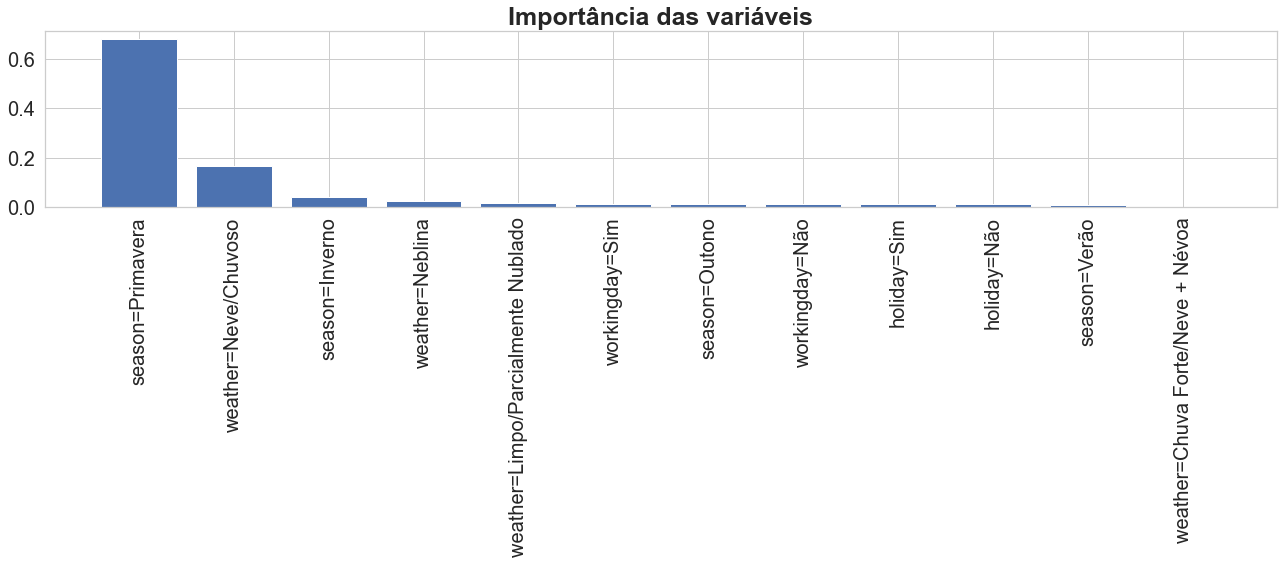

In [64]:
figure, ax = plt.subplots(figsize=(18, 8))
feature_importance = pd.DataFrame({"feature": clf.feature_names_in_, "importance": clf.feature_importances_}).sort_values("importance", ascending=False)
plt.bar(feature_importance.feature, feature_importance.importance)

ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
plt.title("Importância das variáveis", weight='bold', fontsize=25)
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig(f"preproc/pre_feature_importance.png")
plt.show()

In [65]:
feature_importance.importance.cumsum()

2     0.680151
7     0.848499
0     0.888575
6     0.912994
5     0.930257
11    0.942858
1     0.955197
10    0.966958
9     0.978503
8     0.989930
3     0.999977
4     1.000000
Name: importance, dtype: float64